# Part 1 

Le but de cette première partie est de faire un LSTM simple pour déterminer si une review est positive ou négative en la comparant à la note associée 

In [ ]:
from wordcloud import WordCloudc
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Restaurant reviews.csv')
data.head()


2024-11-02 16:58:19.995416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Data Preprocessing
To use text data in an LSTM model, we need to preprocess it by converting text to sequences and encoding the labels as binary classes (positive or negative).

In [3]:
import pandas as pd
import numpy as np

# Première inspection du dataset

print(data.shape)

print(data.info())

(10000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB
None


In [4]:
#On se débarasse des colonnes inutiles 

data = data.drop(["Reviewer", "Metadata", "Pictures" ,"7514"], axis=1)
print(data.shape)

print(data.info())

(10000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Review      9955 non-null   object
 2   Rating      9962 non-null   object
 3   Time        9962 non-null   object
dtypes: object(4)
memory usage: 312.6+ KB
None


In [5]:
ratinf_df = data["Rating"]
reviews_df = data 
rating_out_df = data.drop(columns=["Rating"])
reviews_df.shape

(10000, 4)

In [6]:
# reviews_df.info montre des lignes avec des cases vides et un rating dans un format non-numérique

reviews_df['Rating'] = pd.to_numeric(reviews_df['Rating'], errors='coerce')

# On supprime les lignes vides 

reviews_df = reviews_df.dropna(subset=['Rating'])
reviews_df = reviews_df.dropna(subset=['Review'])

print(reviews_df.shape)
print(reviews_df.info())

(9954, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 9954 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  9954 non-null   object 
 1   Review      9954 non-null   object 
 2   Rating      9954 non-null   float64
 3   Time        9954 non-null   object 
dtypes: float64(1), object(3)
memory usage: 388.8+ KB
None


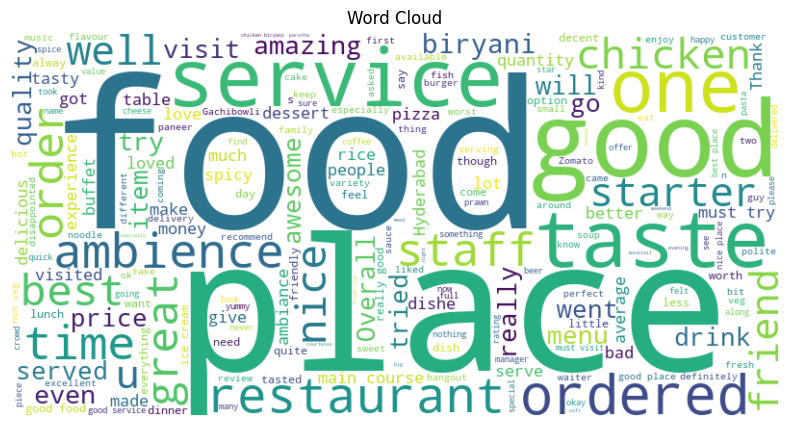

In [7]:
from wordcloud import WordCloud

all_words = ' '.join(reviews_df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()


In [8]:
# Note >=3 veut dire review positive, sinon négative. J'ai essayé avec 4 mais je considère que à partir de 3 c'est une note correcte
threshold_rating = 3
reviews_df['Sentiment'] = reviews_df['Rating'].apply(lambda x: 1 if x >= threshold_rating else 0)

texts = reviews_df['Review'].astype(str).tolist()
labels = reviews_df['Sentiment'].values

# Tokenize les reviews
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)
y = labels

# Split des données en entrainement et validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Building and Training the LSTM Model
We'll build a Bidirectional LSTM model to capture sequential dependencies in the review texts and train it on our labeled data.

In [9]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrainement du modèle, je teste sur 30 epochs. Peut-être overfitting, 15 epochs semble assez.
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)


/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
184/200 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7789 - loss: 0.4722

KeyboardInterrupt: 

## Model Evaluation
We'll evaluate our model on the test set to determine its accuracy and analyze its performance with a classification report and confusion matrix.

In [ ]:
# Lancement des prédictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Accuracy: 0.8814665996986439

Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.77      0.77       501
    Positive       0.92      0.92      0.92      1490

    accuracy                           0.88      1991
   macro avg       0.84      0.84      0.84      1991
weighted avg       0.88      0.88      0.88      1991


Confusion Matrix:
 [[ 386  115]
 [ 121 1369]]


## Training and Validation Accuracy and Loss
Let's plot the training and validation accuracy and loss to visualize how well the model trained over epochs.

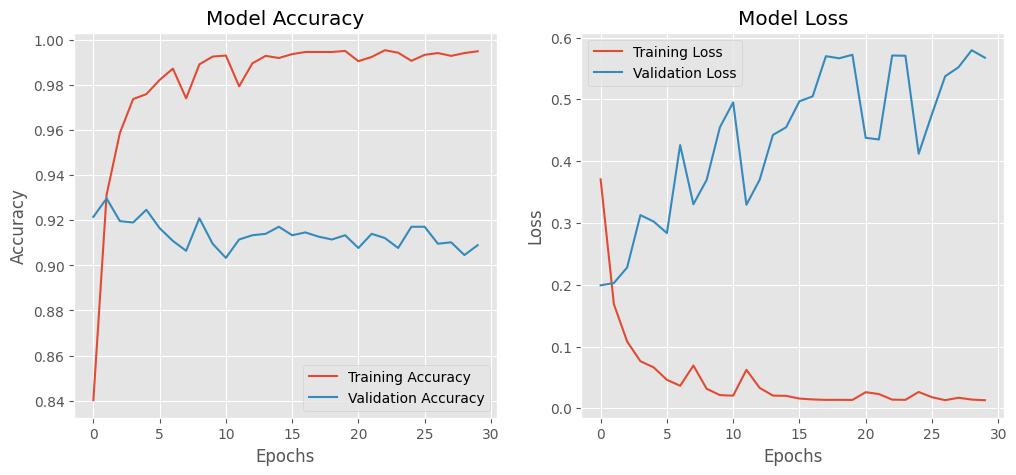

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot précision
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot perte
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


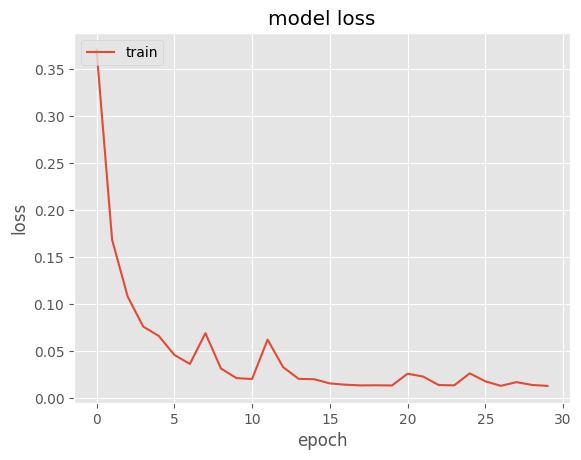

In [ ]:
plt.style.use('ggplot')
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()